<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/3_updated_Time_Series_Momentum_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Momentum - updated 2023

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




vctrs (0.6.4 -> 0.6.5) [CRAN]
bit   (4.0.4 -> 4.0.5) [CRAN]
cpp11 (0.4.6 -> 0.4.7) [CRAN]


Installing 3 packages: vctrs, bit, cpp11

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



fansi    (1.0.5    -> 1.0.6   ) [CRAN]
processx (3.8.2    -> 3.8.3   ) [CRAN]
pkgbuild (1.4.2    -> 1.4.3   ) [CRAN]
desc     (1.4.2    -> 1.4.3   ) [CRAN]
progress (1.2.2    -> 1.2.3   ) [CRAN]
openssl  (2.0.6    -> 2.1.1   ) [CRAN]
jsonlite (1.8.7    -> 1.8.8   ) [CRAN]
curl     (5.0.2    -> 5.2.0   ) [CRAN]
gargle   (1.5.1    -> 1.5.2   ) [CRAN]
brio     (1.1.3    -> 1.1.4   ) [CRAN]
vroom    (1.6.4    -> 1.6.5   ) [CRAN]
testthat (3.2.0    -> 3.2.1   ) [CRAN]
arrow    (13.0.0.1 -> 14.0.0.2) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpCdtB6P/remotesd667a51133/RWLab-rwRtools-9f16cfc/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.66.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex market cap data



In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

head(market_cap)

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,MarketCapUSD
<chr>,<date>,<dbl>
AGRS,2017-01-01,5.421921e+06
ATOM,2017-01-01,6.955437e+04
BTC,2017-01-01,1.568633e+10
DASH,2017-01-01,7.873666e+07
DCR,2017-01-01,1.702669e+06
DGB,2017-01-01,1.970633e+06


## Load Binance spot OHLCV data

In [4]:
prices <- rwRtools::crypto_get_binance_spot_1h()
head(prices)

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 830.3 Mb )





File successfully transferred


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


# Creating research universe

In [5]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 22)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
min_constituents <- 10
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=min_constituents, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4336.80,72153449099,1,FALSE
2017-08-17,ETH,306.74,28752742413,2,FALSE
2017-08-18,BTC,4113.75,70206129858,1,FALSE
2017-08-18,ETH,293.74,28406320026,2,FALSE
2017-08-19,BTC,4139.98,67500579074,1,FALSE
2017-08-19,ETH,290.91,27839631816,2,FALSE


## Time Series Momentum

`geom_smooth()` using formula = 'y ~ x'


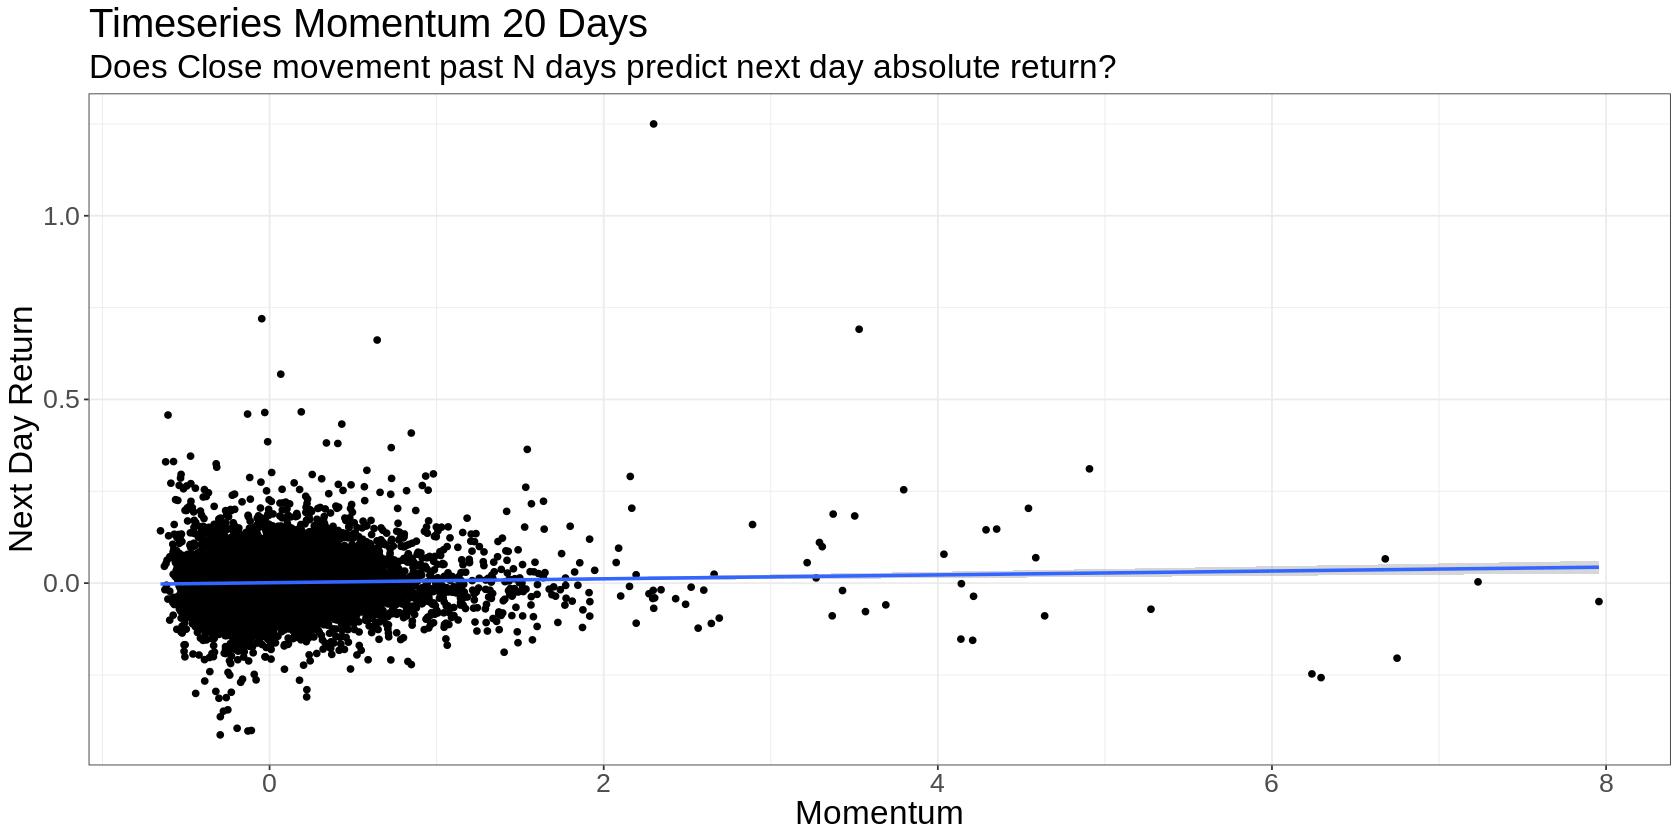

In [6]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = Close / lag(Close, n = 20) - 1,
    lagmomo20 = lag(momo20)
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Close) / Close),
    fwd_simple_return = lead(Close) / Close - 1
  ) %>%
  na.omit() %>%
  ungroup()

returns %>%
  filter(is_index == TRUE ) %>%
  na.omit() %>%
  ggplot(aes(x = momo20, y = fwd_simple_return)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  labs(
    title = "Timeseries Momentum 20 Days",
    subtitle = "Does Close movement past N days predict next day absolute return?",
    x = 'Momentum',
    y = 'Next Day Return'
  )

Similar to the original research.

Let's look at some more lookbacks...

`geom_smooth()` using formula = 'y ~ x'


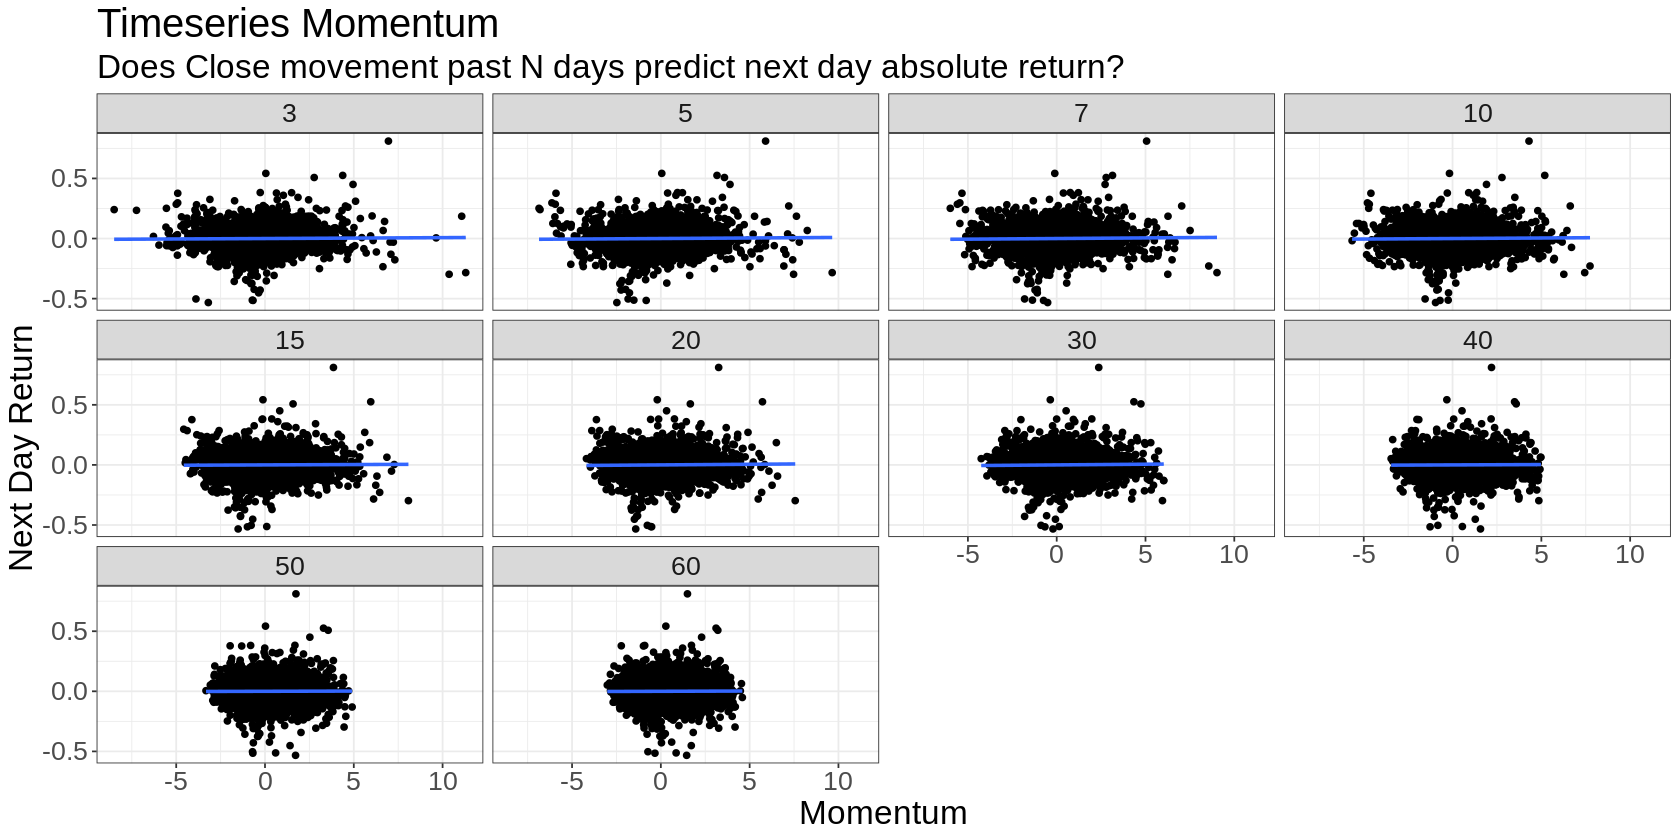

In [7]:
lookback_returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate N day momentum features
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = log(Close / lag(Close, n = 3)),
    "5" = log(Close / lag(Close, n = 5)),
    "7" = log(Close / lag(Close, n = 7)),
    "10" = log(Close / lag(Close, n = 10)),
    "15" = log(Close / lag(Close, n = 15)),
    "20" = log(Close / lag(Close, n = 20)),
    "30" = log(Close / lag(Close, n = 30)),
    "40" = log(Close / lag(Close, n = 40)),
    "50" = log(Close / lag(Close, n = 50)),
    "60" = log(Close / lag(Close, n = 60)),
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Close) / Close),
    fwd_simple_return = lead(Close) / Close - 1
  ) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback)) %>%
  # Zscore all the returns to scale them
  group_by(lookback, Ticker) %>%
  mutate(momo_zscore = (momo - mean(momo)) / sd(momo)) %>%
  mutate(momo_decile = ntile(momo, 10))

lookback_returns %>%
  filter(is_index == TRUE ) %>%
  na.omit() %>%
  ggplot(aes(x=momo_zscore,y=fwd_log_return)) +
  geom_point() +
  geom_smooth(method = 'lm') +
  labs(
    title = "Timeseries Momentum",
    subtitle = "Does Close movement past N days predict next day absolute return?",
    x = 'Momentum',
    y = 'Next Day Return'
  ) +
  facet_wrap(~lookback)


Same universe.

Calculate 20 day momentum factor.

For each asset, rank all the momentum observations into deciles *over the full population*.

Group by decile, plot mean next day log return.

Each sub-plot is a different year.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


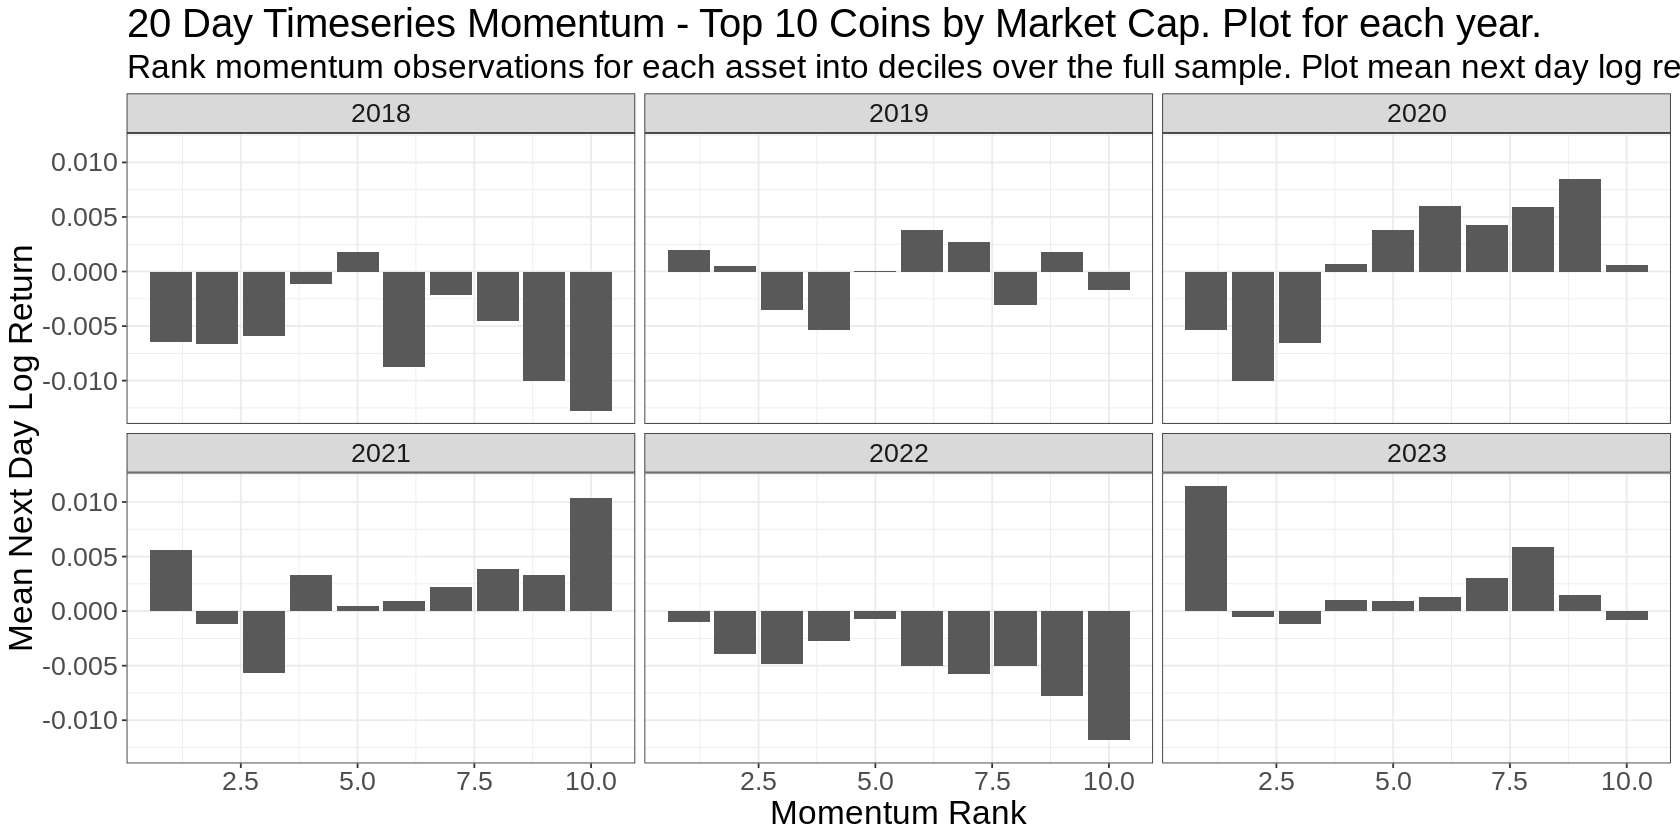

In [8]:
lookback_returns %>%
  filter(is_index == TRUE ) %>%
  mutate(year = year(Date)) %>%
  filter(lookback == 20) %>%
  group_by(year, momo_decile) %>%
  summarise(fwd_log_return = mean(fwd_log_return)) %>%
  na.omit() %>%
  ggplot(aes(x = momo_decile,y = fwd_log_return)) +
  geom_bar(stat='identity') +
  labs(
    title = "20 Day Timeseries Momentum - Top 10 Coins by Market Cap. Plot for each year.",
    subtitle = "Rank momentum observations for each asset into deciles over the full sample. Plot mean next day log returns",
    x = 'Momentum Rank',
    y = 'Mean Next Day Log Return'
  ) +
  facet_wrap(~year)

Interesting. We see a reversal effrect in decile 1, and weak-ish trend effects elsewhere, with exceptions.

Same universe.

Calculate momentum factor.

For each asset, rank all the momentum observations into deciles *over the full population*.

Group by decile, plot mean next day log return.

Each sub-plot is a different momentum lookback.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


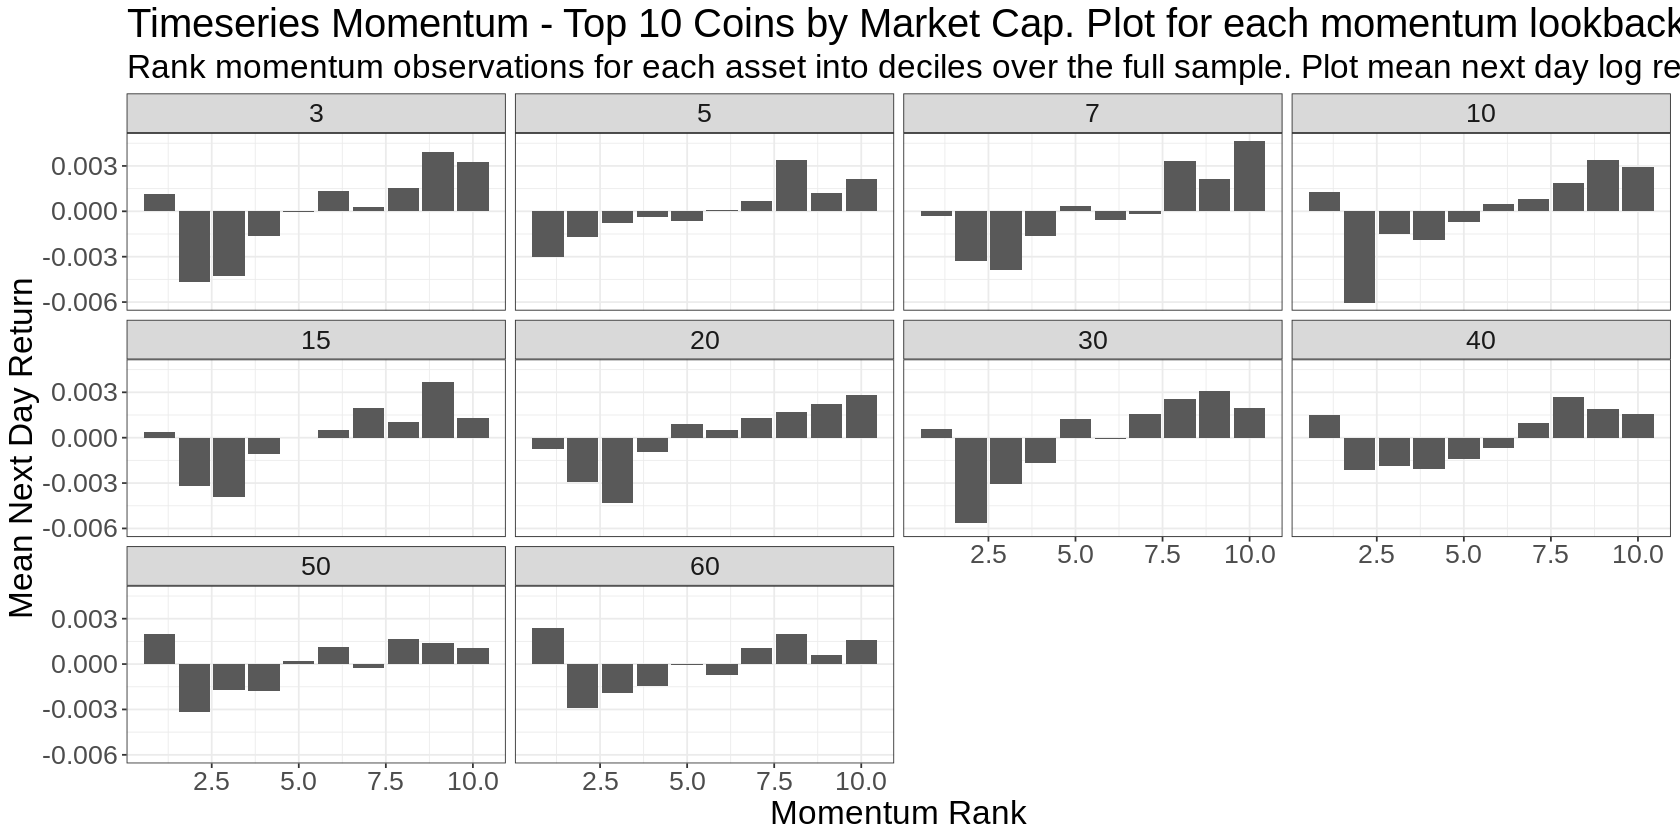

In [9]:
lookback_returns %>%
  filter(is_index == TRUE ) %>%
  group_by(lookback, momo_decile) %>%
  mutate(lookback = factor(lookback)) %>%
  summarise(fwd_log_return = mean(fwd_log_return)) %>%
  na.omit() %>%
  ggplot(aes(x=momo_decile,y=fwd_log_return)) +
  geom_bar(stat='identity') +
  labs(
    title = "Timeseries Momentum - Top 10 Coins by Market Cap. Plot for each momentum lookback.",
    subtitle = "Rank momentum observations for each asset into deciles over the full sample. Plot mean next day log returns",
    x = 'Momentum Rank',
    y = 'Mean Next Day Return'
  ) +
  facet_wrap(~lookback)

Reversal effect in decile 1 is apparent here too - maybe due to bias in the universe.   

We see clear trend effects elsewhere.

# Summary

This looks similar to how it looked in the original research.